# Imports

## Packages

In [19]:
import pandas as pd
import holidays
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# import sklearn
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA

# Prophet model for time series forecast
# !pip install yfinance prophet

import warnings
warnings.filterwarnings('ignore')

In [20]:
from helper import *

## Data

In [21]:
df = pd.read_csv('./data/DK_2.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
# df['Timestamp'] = pd.to_datetime(df['Timestamp'], format = '%Y%m%d %H:%M:%S')
# df['Date'] = pd.to_datetime(df['Date'], format = '%Y %m %d')

# Pre-processing

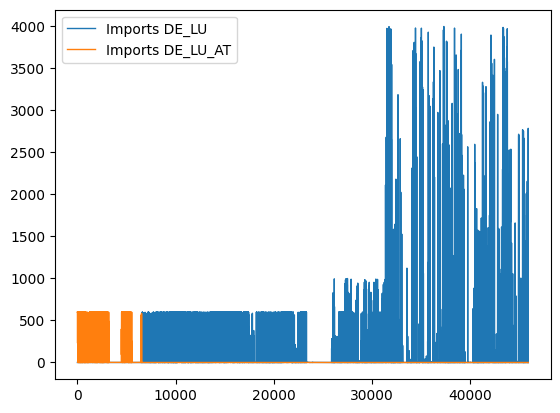

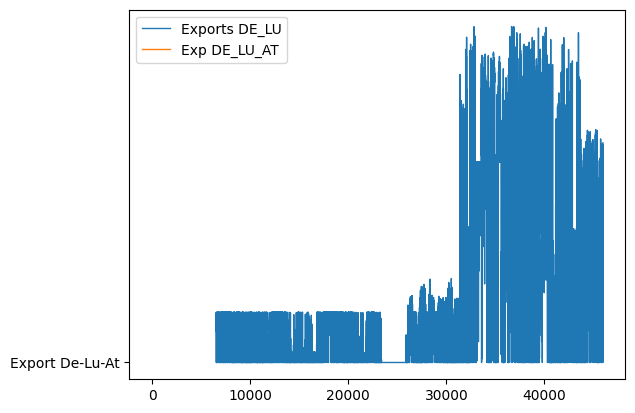

In [22]:
plt.plot(df['DE_LU'], linewidth = 1, label = 'Imports DE_LU')
plt.plot(df['DE_AT_LU'], linewidth = 1, label = 'Imports DE_LU_AT')
plt.legend()
plt.show()
plt.plot(df['Export De-Lu'], linewidth = 1, label = 'Exports DE_LU')
plt.plot(['Export De-Lu-At'], linewidth = 1, label = 'Exp DE_LU_AT')
plt.legend()
plt.show()

In [23]:
cols_na = ['Export De-Lu', 'Export De-Lu-At', 'DE_AT_LU', 'DE_LU']
for col in cols_na:
    df[col].fillna(0, inplace = True)

In [24]:
df['DE_LU_corr'] = df['DE_AT_LU'] + df['DE_LU']
df.drop(['DE_AT_LU', 'DE_LU'], axis = 1, inplace = True)

df['Export DE_LU_corr'] = df['Export De-Lu'] + df['Export De-Lu-At']
df.drop(['Export De-Lu', 'Export De-Lu-At'], axis = 1, inplace = True)

In [25]:
df = get_dt_info(df, 'Timestamp', yr = True, qt = True, mo = True, day = True, date = True, h = True)
df = get_dt_info(df, 'Date', w = True)
df.tail().T

,45979,45980,45981,45982,45983
Timestamp,2023-03-31 19:00:00,2023-03-31 20:00:00,2023-03-31 21:00:00,2023-03-31 22:00:00,2023-03-31 23:00:00
Date,2023-03-31 00:00:00,2023-03-31 00:00:00,2023-03-31 00:00:00,2023-03-31 00:00:00,2023-03-31 00:00:00
TTF,NaN,NaN,NaN,NaN,NaN
CO2,NaN,NaN,NaN,NaN,NaN
coal,177.25,177.25,177.25,177.25,177.25
Day-ahead prices,NaN,NaN,NaN,NaN,NaN
Forecasted Load,NaN,NaN,NaN,NaN,NaN
Actual Load,NaN,NaN,NaN,NaN,NaN
Solar,NaN,NaN,NaN,NaN,NaN
Wind Offshore,NaN,NaN,NaN,NaN,NaN


## Differentiate business and non-business days

In [26]:
country = 'DK'
country_calendar = getattr(holidays, country)
test = pd.tseries.offsets.CustomBusinessDay(calendar = country_calendar)

In [27]:
test = add_business_days(df, 'DK', inplace = True)
test

From 2018-01-01 00:00:00 to 2023-03-31 00:00:00


,Timestamp,Date,TTF,CO2,coal,Day-ahead prices,Forecasted Load,Actual Load,Solar,Wind Offshore,...,Export SE4,DE_LU_corr,Export DE_LU_corr,Year,Quarter,Month,Day,Hour,Week,Business
0,2018-01-01 00:00:00,2018-01-01,NaN,NaN,NaN,26.33,1591.0,1607.0,0.0,245.0,...,880.0,600.0,0.0,2018,1,1,1,0,1,True
1,2018-01-01 01:00:00,2018-01-01,NaN,NaN,NaN,26.43,1541.0,1566.0,0.0,264.0,...,882.0,600.0,0.0,2018,1,1,1,1,1,True
2,2018-01-01 02:00:00,2018-01-01,NaN,NaN,NaN,26.10,1497.0,1460.0,0.0,291.0,...,922.0,600.0,0.0,2018,1,1,1,2,1,True
3,2018-01-01 03:00:00,2018-01-01,NaN,NaN,NaN,24.70,1426.0,1424.0,0.0,300.0,...,1087.0,600.0,0.0,2018,1,1,1,3,1,True
4,2018-01-01 04:00:00,2018-01-01,NaN,NaN,NaN,24.74,1378.0,1380.0,0.0,336.0,...,1095.0,600.0,0.0,2018,1,1,1,4,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45979,2023-03-31 19:00:00,2023-03-31,NaN,NaN,177.25,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,2023,1,3,31,19,13,True
45980,2023-03-31 20:00:00,2023-03-31,NaN,NaN,177.25,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,2023,1,3,31,20,13,True
45981,2023-03-31 21:00:00,2023-03-31,NaN,NaN,177.25,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,2023,1,3,31,21,13,True
45982,2023-03-31 22:00:00,2023-03-31,NaN,NaN,177.25,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,2023,1,3,31,22,13,True


In [28]:
# calendar of holidays in DK
dk_bus = pd.tseries.offsets.CustomBusinessDay(calendar = holidays.DK(years = [2018, 2023]))

# range of business days, excluding weekends and holidays
dk_bus_days = pd.bdate_range(min(df['Date']), max(df['Date']), freq = dk_bus)
df['business'] = df['Date'].isin(dk_bus_days)

In [29]:
(df['business'] != test['Business']).sum()

0

# Imputation

In [30]:
# check for NaN values
for col in df.columns:
    a = df[col].isna().sum()
    if a > 0:
        b = df[(df[col].isna()) & (df['business'] == True)]
        print(col, a, 'of which', len(b), 'in', len(b['Date'].unique()),'business days')

TTF 15672 of which 2568 in 107 business days
CO2 15096 of which 1992 in 83 business days
coal 13440 of which 336 in 14 business days
Day-ahead prices 24 of which 24 in 1 business days
Forecasted Load 25 of which 25 in 2 business days
Actual Load 25 of which 25 in 2 business days
Solar 313 of which 215 in 14 business days
Wind Offshore 121 of which 97 in 7 business days
Wind Onshore 169 of which 145 in 10 business days
DK_1 25 of which 25 in 2 business days
SE_4 25 of which 25 in 2 business days
Export DK1 25 of which 25 in 2 business days
Export SE4 25 of which 25 in 2 business days


In [31]:
# in most cases, 'TTF' and 'CO2' NaN are in non-business days, where the price is the same as the last business day --> ffill
for col in ['TTF', 'CO2']:
    df[col].fillna(method = 'ffill', inplace = True)

In [32]:
# check for NaN values
for col in df.columns:
    a = df[col].isna().sum()
    if a > 0:
        b = df[(df[col].isna()) & (df['business'])]
        print(col, a, 'of which', len(b), 'in', len(b['Date'].unique()),'business days')

TTF 24 of which 24 in 1 business days
CO2 24 of which 24 in 1 business days
coal 13440 of which 336 in 14 business days
Day-ahead prices 24 of which 24 in 1 business days
Forecasted Load 25 of which 25 in 2 business days
Actual Load 25 of which 25 in 2 business days
Solar 313 of which 215 in 14 business days
Wind Offshore 121 of which 97 in 7 business days
Wind Onshore 169 of which 145 in 10 business days
DK_1 25 of which 25 in 2 business days
SE_4 25 of which 25 in 2 business days
Export DK1 25 of which 25 in 2 business days
Export SE4 25 of which 25 in 2 business days


In [33]:
idx_drop = []
for col in ['TTF', 'CO2', 'Day-ahead prices']:
    print(col, df[df[col].isna()]['Date'].unique())
    idx_drop.append(df[df[col].isna()]['Date'].unique()[0])

idx_drop = set(idx_drop)

TTF <DatetimeArray>
['2018-01-01 00:00:00']
Length: 1, dtype: datetime64[ns]
CO2 <DatetimeArray>
['2018-01-01 00:00:00']
Length: 1, dtype: datetime64[ns]
Day-ahead prices <DatetimeArray>
['2023-03-31 00:00:00']
Length: 1, dtype: datetime64[ns]


In [34]:
# some NaNs are in the 1st and last day of the whole dataset, all observations for those days are dropped
df.drop(df[df['Date'].isin(idx_drop)].index, inplace = True)

In [35]:
# check for NaN values
cols_na = []
for col in df.columns:
    a = df[col].isna().sum()
    if a > 0:
        cols_na.append(col)
        b = df[df[col].isna()]['Date'].unique()
        print(col, a, '\nbusiness days', len(b), b)

coal 13416 
business days 559 <DatetimeArray>
['2018-01-06 00:00:00', '2018-01-07 00:00:00', '2018-01-13 00:00:00',
 '2018-01-14 00:00:00', '2018-01-20 00:00:00', '2018-01-21 00:00:00',
 '2018-01-27 00:00:00', '2018-01-28 00:00:00', '2018-02-03 00:00:00',
 '2018-02-04 00:00:00',
 ...
 '2023-02-25 00:00:00', '2023-02-26 00:00:00', '2023-03-04 00:00:00',
 '2023-03-05 00:00:00', '2023-03-11 00:00:00', '2023-03-12 00:00:00',
 '2023-03-18 00:00:00', '2023-03-19 00:00:00', '2023-03-25 00:00:00',
 '2023-03-26 00:00:00']
Length: 559, dtype: datetime64[ns]
Forecasted Load 1 
business days 1 <DatetimeArray>
['2023-03-30 00:00:00']
Length: 1, dtype: datetime64[ns]
Actual Load 1 
business days 1 <DatetimeArray>
['2023-03-30 00:00:00']
Length: 1, dtype: datetime64[ns]
Solar 289 
business days 21 <DatetimeArray>
['2020-03-01 00:00:00', '2020-03-02 00:00:00', '2021-10-07 00:00:00',
 '2021-10-08 00:00:00', '2021-10-13 00:00:00', '2021-10-14 00:00:00',
 '2022-04-30 00:00:00', '2022-05-01 00:00:00', '20

In [36]:
df_temp = df.copy()
df_temp[(df_temp['Hour'] == 17) & ('2020-09-03'< df_temp['Date']) & (df_temp['Date'] <'2020-09-15')]

,Timestamp,Date,TTF,CO2,coal,Day-ahead prices,Forecasted Load,Actual Load,Solar,Wind Offshore,...,DE_LU_corr,Export DE_LU_corr,Year,Quarter,Month,Day,Hour,Week,Business,business
23465,2020-09-04 17:00:00,2020-09-04,11.680,28.13,49.00,47.95,1590.0,1601.0,27.0,148.0,...,2.0,0.0,2020,3,9,4,17,36,True,True
23489,2020-09-05 17:00:00,2020-09-05,11.680,28.13,NaN,37.29,1483.0,1483.0,30.0,218.0,...,3.0,0.0,2020,3,9,5,17,36,False,False
23513,2020-09-06 17:00:00,2020-09-06,11.680,28.13,NaN,42.01,1484.0,1491.0,30.0,112.0,...,3.0,0.0,2020,3,9,6,17,36,False,False
23537,2020-09-07 17:00:00,2020-09-07,11.680,27.81,48.50,56.12,1619.0,1616.0,31.0,113.0,...,2.0,0.0,2020,3,9,7,17,37,True,True
23561,2020-09-08 17:00:00,2020-09-08,10.800,27.53,48.75,49.68,1659.0,1632.0,28.0,241.0,...,3.0,0.0,2020,3,9,8,17,37,True,True
23585,2020-09-09 17:00:00,2020-09-09,10.735,27.94,48.80,46.65,1650.0,1643.0,12.0,269.0,...,2.0,0.0,2020,3,9,9,17,37,True,True
23609,2020-09-10 17:00:00,2020-09-10,10.515,29.15,49.75,65.81,1602.0,1612.0,27.0,56.0,...,2.0,0.0,2020,3,9,10,17,37,True,True
23633,2020-09-11 17:00:00,2020-09-11,10.495,28.99,50.75,56.76,1568.0,1598.0,24.0,23.0,...,0.0,0.0,2020,3,9,11,17,37,True,True
23657,2020-09-12 17:00:00,2020-09-12,10.495,28.99,NaN,33.02,1556.0,1550.0,17.0,279.0,...,0.0,0.0,2020,3,9,12,17,37,False,False
23681,2020-09-13 17:00:00,2020-09-13,10.495,28.99,NaN,30.34,1588.0,1607.0,22.0,254.0,...,0.0,0.0,2020,3,9,13,17,37,False,False


In [37]:
for i in range(24):
    check = df_temp[df_temp['Hour'] == i][cols_na].rolling(4, min_periods = 1, closed = 'left', axis = 'rows').mean()
    df_temp[cols_na].fillna(value = check, inplace = True)

In [38]:
df_temp.iloc[23555:23565, :]

,Timestamp,Date,TTF,CO2,coal,Day-ahead prices,Forecasted Load,Actual Load,Solar,Wind Offshore,...,DE_LU_corr,Export DE_LU_corr,Year,Quarter,Month,Day,Hour,Week,Business,business
23579,2020-09-09 11:00:00,2020-09-09,10.735,27.94,48.8,29.82,1690.0,1692.0,46.0,278.0,...,2.0,0.0,2020,3,9,9,11,37,True,True
23580,2020-09-09 12:00:00,2020-09-09,10.735,27.94,48.8,29.79,1685.0,1685.0,54.0,291.0,...,2.0,0.0,2020,3,9,9,12,37,True,True
23581,2020-09-09 13:00:00,2020-09-09,10.735,27.94,48.8,29.21,1665.0,1663.0,45.0,275.0,...,2.0,0.0,2020,3,9,9,13,37,True,True
23582,2020-09-09 14:00:00,2020-09-09,10.735,27.94,48.8,29.17,1635.0,1640.0,40.0,266.0,...,2.0,0.0,2020,3,9,9,14,37,True,True
23583,2020-09-09 15:00:00,2020-09-09,10.735,27.94,48.8,30.41,1669.0,1645.0,32.0,290.0,...,2.0,0.0,2020,3,9,9,15,37,True,True
23584,2020-09-09 16:00:00,2020-09-09,10.735,27.94,48.8,32.45,1712.0,1691.0,22.0,286.0,...,2.0,0.0,2020,3,9,9,16,37,True,True
23585,2020-09-09 17:00:00,2020-09-09,10.735,27.94,48.8,46.65,1650.0,1643.0,12.0,269.0,...,2.0,0.0,2020,3,9,9,17,37,True,True
23586,2020-09-09 18:00:00,2020-09-09,10.735,27.94,48.8,46.88,1553.0,1558.0,2.0,253.0,...,2.0,0.0,2020,3,9,9,18,37,True,True
23587,2020-09-09 19:00:00,2020-09-09,10.735,27.94,48.8,32.68,1454.0,1537.0,0.0,234.0,...,2.0,0.0,2020,3,9,9,19,37,True,True
23588,2020-09-09 20:00:00,2020-09-09,10.735,27.94,48.8,28.59,1330.0,1417.0,0.0,259.0,...,2.0,0.0,2020,3,9,9,20,37,True,True


In [39]:
# check for NaN values
for col in df_temp.columns:
    a = df_temp[col].isna().sum()
    if a > 0:
        b = df_temp[df_temp[col].isna()]['Date'].unique()
        print(col, a, '\nbusiness days', len(b), b)

coal 13416 
business days 559 <DatetimeArray>
['2018-01-06 00:00:00', '2018-01-07 00:00:00', '2018-01-13 00:00:00',
 '2018-01-14 00:00:00', '2018-01-20 00:00:00', '2018-01-21 00:00:00',
 '2018-01-27 00:00:00', '2018-01-28 00:00:00', '2018-02-03 00:00:00',
 '2018-02-04 00:00:00',
 ...
 '2023-02-25 00:00:00', '2023-02-26 00:00:00', '2023-03-04 00:00:00',
 '2023-03-05 00:00:00', '2023-03-11 00:00:00', '2023-03-12 00:00:00',
 '2023-03-18 00:00:00', '2023-03-19 00:00:00', '2023-03-25 00:00:00',
 '2023-03-26 00:00:00']
Length: 559, dtype: datetime64[ns]
Forecasted Load 1 
business days 1 <DatetimeArray>
['2023-03-30 00:00:00']
Length: 1, dtype: datetime64[ns]
Actual Load 1 
business days 1 <DatetimeArray>
['2023-03-30 00:00:00']
Length: 1, dtype: datetime64[ns]
Solar 289 
business days 21 <DatetimeArray>
['2020-03-01 00:00:00', '2020-03-02 00:00:00', '2021-10-07 00:00:00',
 '2021-10-08 00:00:00', '2021-10-13 00:00:00', '2021-10-14 00:00:00',
 '2022-04-30 00:00:00', '2022-05-01 00:00:00', '20

In [41]:
df_temp.to_csv('./data/DK_2_filled.csv', index = False)

# Lagging

In [42]:
df_lag = pd.DataFrame(df_temp['Day-ahead prices'].copy())
df_lag['DAP-lag24'] = df_lag['Day-ahead prices'].shift(24) # 1 day
df_lag['DAP-lag25'] = df_lag['Day-ahead prices'].shift(25) # 25 h
df_lag['DAP-lag26'] = df_lag['Day-ahead prices'].shift(26) # 26 h
df_lag['DAP-lag27'] = df_lag['Day-ahead prices'].shift(27) # 27 h
df_lag['DAP-lag28'] = df_lag['Day-ahead prices'].shift(28) # 28 h
df_lag['DAP-lag29'] = df_lag['Day-ahead prices'].shift(29) # 29 h
df_lag['DAP-lag30'] = df_lag['Day-ahead prices'].shift(30) # 30 h
df_lag['DAP-lag31'] = df_lag['Day-ahead prices'].shift(31) # 31 h
df_lag['DAP-lag32'] = df_lag['Day-ahead prices'].shift(32) # 32 h
df_lag['DAP-lag33'] = df_lag['Day-ahead prices'].shift(33) # 33 h
df_lag['DAP-lag34'] = df_lag['Day-ahead prices'].shift(34) # 34 h
df_lag['DAP-lag35'] = df_lag['Day-ahead prices'].shift(35) # 35 h
df_lag['DAP-lag36'] = df_lag['Day-ahead prices'].shift(36) # 36 h
df_lag['DAP-lag48'] = df_lag['Day-ahead prices'].shift(24*2) # 2 days
df_lag['DAP-lag72'] = df_lag['Day-ahead prices'].shift(24*3) # 2 days
df_lag['DAP-lag168'] = df_lag['Day-ahead prices'].shift(24*7) # 1 week
df_lag['DAP-lag720'] = df_lag['Day-ahead prices'].shift(24*30) # 1 month
df_lag['DAP-lag2160'] = df_lag['Day-ahead prices'].shift(24*30*3) # 3 months
df_lag['DAP-lag8760'] = df_lag['Day-ahead prices'].shift(24*365) # 1 year
df_lag['DAP-lag-168'] = df_lag['Day-ahead prices'].shift(-24*7) # 1 week ahead

In [43]:
df_lag.head()

,Day-ahead prices,DAP-lag24,DAP-lag25,DAP-lag26,DAP-lag27,DAP-lag28,DAP-lag29,DAP-lag30,DAP-lag31,DAP-lag32,...,DAP-lag34,DAP-lag35,DAP-lag36,DAP-lag48,DAP-lag72,DAP-lag168,DAP-lag720,DAP-lag2160,DAP-lag8760,DAP-lag-168
24,18.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.17
25,14.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.10
26,17.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.79
27,24.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.99
28,17.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.24


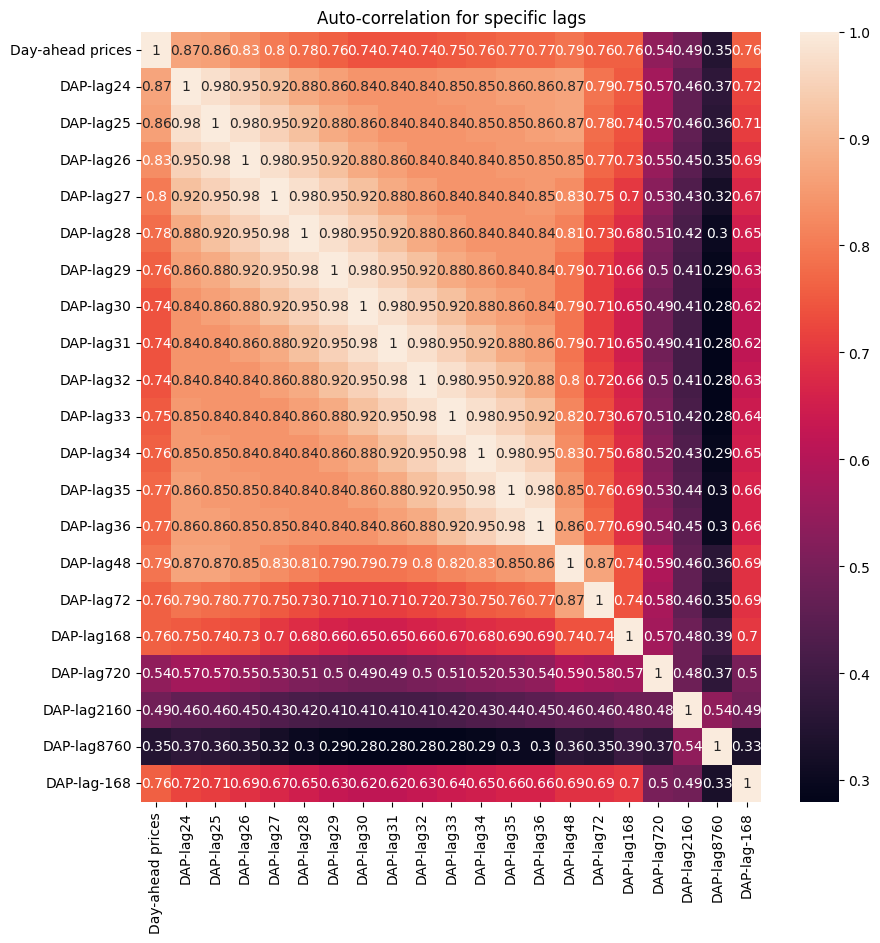

In [44]:
plt.figure(figsize = (10,10))
matrix = df_lag.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.title('Auto-correlation for specific lags')
plt.show()

In [45]:
lags = [24, 36, 48, 72, 168, -168]

In [46]:
df_lag = df.drop(['Timestamp'], axis =  1)
for lag in lags:
    df_lag['DAP-lag'+str(lag)] = df_lag['Day-ahead prices'].shift(lag)

In [47]:
matrix = df_lag.corr().round(1)

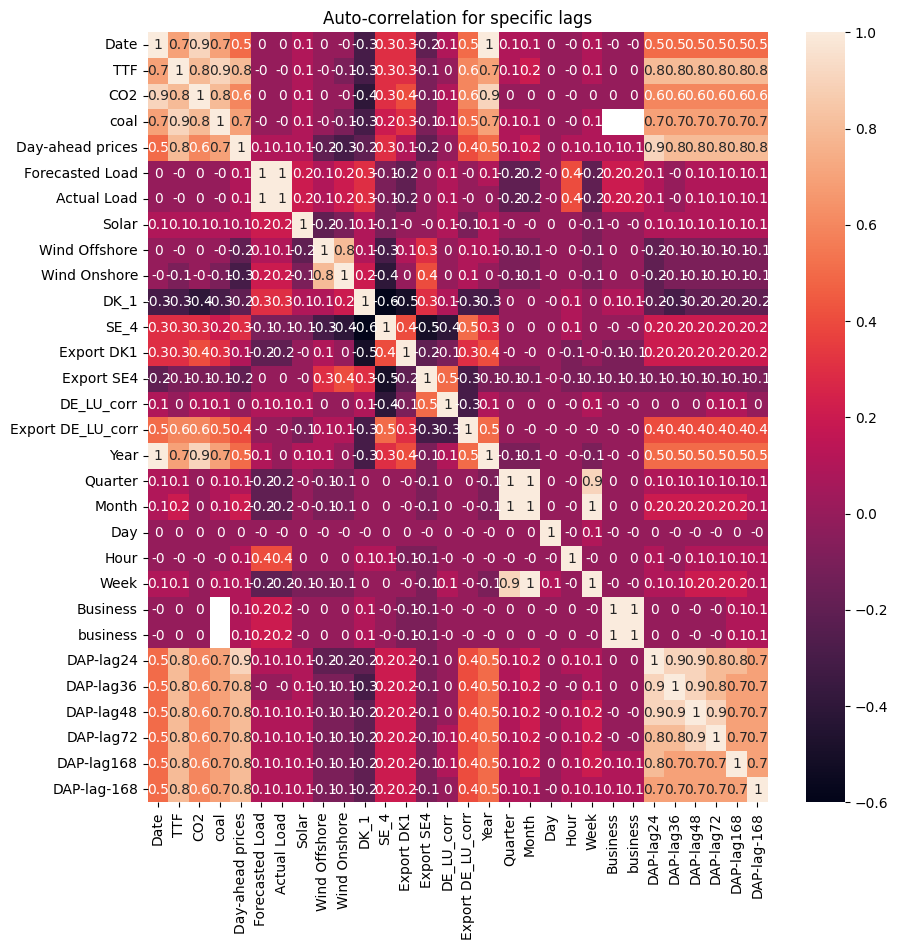

In [48]:
plt.figure(figsize = (10,10))
sns.heatmap(matrix, annot=True)
plt.title('Auto-correlation for specific lags')
plt.show()

In [49]:
df_lag.to_csv('./data/DK_2_lagged.csv', index = False)

# PCA

In [50]:
df_lag_nan = df_lag.dropna(how = 'any', axis = 'index')

In [51]:
pca = PCA()
pca.fit(df_lag_nan)
print(pca.explained_variance_ratio_.cumsum())

TypeError: Cannot cast DatetimeArray to dtype float64

## Log transform

$\log$ can't deal with negative values, thus, check how many there are:

In [ ]:
df_temp[df_temp['Day-ahead prices'] < 0].describe()

In [ ]:
plt.plot(df_temp[df_temp['Day-ahead prices'] >= 0]['Day-ahead prices'], label = 'Positive', linewidth = 0, marker = 'o', ms = 0.5)
plt.plot(df_temp[df_temp['Day-ahead prices'] < 0]['Day-ahead prices'], label = 'Negative', linewidth = 0, marker = 'o', ms = 0.5)
plt.title('Day-ahead prices\Time-series')
plt.xlabel('Time')
plt.ylabel('Price\€/MWh')
plt.legend()
plt.show()

In [ ]:
df_temp['Day-ahead prices'].plot.hist(bins = 100)
plt.xlabel('Price\n€/MWh')
plt.title('Day-ahead prices\nHistogram')
plt.show()

In [ ]:
df_log = df_temp[df_temp['Day-ahead prices'] > 0].copy()
df_log['Day-ahead prices log'] = np.log(df_log['Day-ahead prices'])

In [ ]:
df_log['Day-ahead prices log'].plot.hist(bins = 100)
plt.xlabel('Price\n€/MWh')
plt.title('log(Day-ahead prices)\nHistogram')
plt.show()